# Transformer

The Transformer architecture has become the backbone of modern artificial intelligence, driving advancements in natural language processing, computer vision, and multimodal learning. At the heart of AI breakthroughs—including ChatGPT—lies the key innovation of self-attention, which allows models to process and weigh relationships across entire sequences in a parallel fashion. This mechanism was first introduced in the paper [Attention Is All You Need (Vaswani et al., 2017)](https:/arxiv.org/abs/1706.03762), which revolutionized deep learning by replacing recurrent structures with purely attention-driven computation. Understanding transformers, even at a basic level, is crucial for understanding how today's AI models achieve remarkable performance across diverse applications.

This notebook is divided into 3 main parts. The first part is the theoretical discussion of the transformer, its main block ann how they function; the second part is a PyTorch implementation of transformer and third part is a showcase of translation example from English to French.

## Theoretical Overview

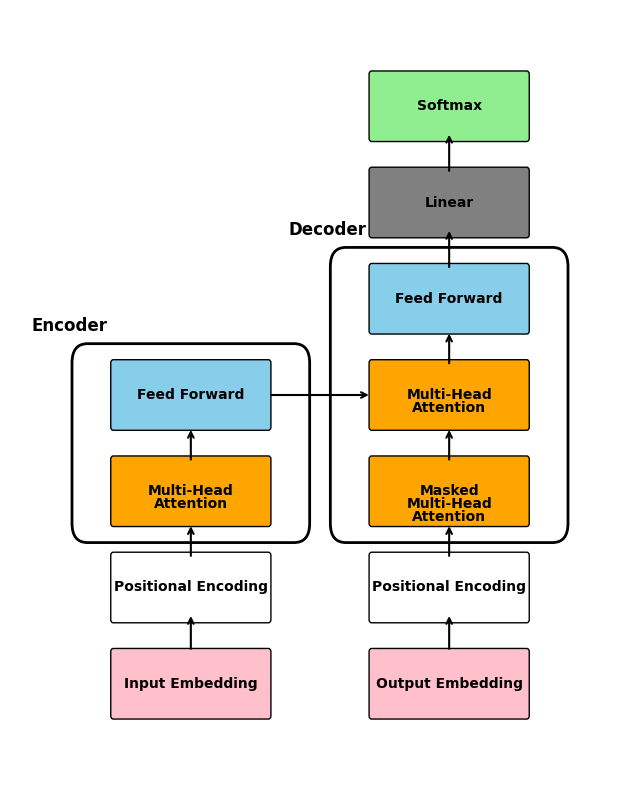

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_rectangle(ax, xy, width, height, text, color="lightgray", textcolor="black", fontsize=10, multiline=False):
    """Draw a labeled rectangle."""
    rect = patches.FancyBboxPatch(xy, width, height, boxstyle="round,pad=0.05", edgecolor="black", facecolor=color)
    ax.add_patch(rect)

    lines = text.split() if multiline else [text]
    for i, line in enumerate(lines):
        ax.text(xy[0] + width / 2, xy[1] + height / 2 - i * 0.2, line, ha="center",
                va="center", fontsize=fontsize, color=textcolor, fontweight="bold")

def draw_arrow(ax, start, end):
    """Draw an arrow from start to end."""
    ax.annotate("", xy=end, xytext=start, arrowprops=dict(arrowstyle="->", color="black", lw=1.5))

def plot_transformer():
    fig, ax = plt.subplots(figsize=(8, 10))
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 12)
    ax.axis("off")

    block_width = 3
    encoder_x = 2
    decoder_x = 7
    spacing = 0.5  # Space between blocks

    # Encoder Layers (bottom-up)
    draw_rectangle(ax, (encoder_x, 1), block_width, 1, "Input Embedding", "pink")
    draw_rectangle(ax, (encoder_x, 2 + spacing), block_width, 1, "Positional Encoding", "white")

    draw_rectangle(ax, (encoder_x, 3 + 2 * spacing), block_width, 1, "Multi-Head\nAttention", "orange", multiline=True)
    draw_rectangle(ax, (encoder_x, 4 + 3 * spacing), block_width, 1, "Feed Forward", "skyblue")

    # Decoder Layers (bottom-up)
    draw_rectangle(ax, (decoder_x, 1), block_width, 1, "Output Embedding", "pink")
    draw_rectangle(ax, (decoder_x, 2 + spacing), block_width, 1, "Positional Encoding", "white")

    draw_rectangle(ax, (decoder_x, 3 + 2 * spacing), block_width, 1, "Masked\nMulti-Head\nAttention", "orange", multiline=True)
    draw_rectangle(ax, (decoder_x, 4 + 3 * spacing), block_width, 1, "Multi-Head\nAttention", "orange", multiline=True)
    draw_rectangle(ax, (decoder_x, 5 + 4 * spacing), block_width, 1, "Feed Forward", "skyblue")

    # Output Layers
    draw_rectangle(ax, (decoder_x, 6 + 5 * spacing), block_width, 1, "Linear", "gray")
    draw_rectangle(ax, (decoder_x, 7 + 6 * spacing), block_width, 1, "Softmax", "lightgreen")

    # Arrows (bottom-up data flow)
    draw_arrow(ax, (encoder_x + block_width/2, 1.5 + spacing), (encoder_x + block_width/2, 2.1 +  spacing))
    draw_arrow(ax, (encoder_x + block_width/2, 2.95 + spacing), (encoder_x + block_width/2, 3 + 2 * spacing))
    draw_arrow(ax, (encoder_x + block_width/2, 3.95 + 2 * spacing), (encoder_x + block_width/2, 4 + 3 * spacing))

    draw_arrow(ax, (decoder_x + block_width/2, 1.5 + spacing), (decoder_x + block_width/2, 2.1 +  spacing))
    draw_arrow(ax, (decoder_x + block_width/2, 2.95 + spacing), (decoder_x + block_width/2, 3 + 2 * spacing))
    draw_arrow(ax, (decoder_x + block_width/2, 3.95 + 2 * spacing), (decoder_x + block_width/2, 4 + 3 * spacing))
    draw_arrow(ax, (decoder_x + block_width/2, 4.95 + 3 * spacing), (decoder_x + block_width/2, 5 + 4 * spacing))
    draw_arrow(ax, (decoder_x + block_width/2, 5.95 + 4 * spacing), (decoder_x + block_width/2, 6.1 + 5 * spacing))
    draw_arrow(ax, (decoder_x + block_width/2, 6.95 + 5 * spacing), (decoder_x + block_width/2, 7.1 + 6 * spacing))

    # Arrow from encoder to decoder cross-attention (Multi-Head Attention in decoder)
    draw_arrow(ax, (encoder_x + block_width, 3.5 + 5 * spacing), (decoder_x, 3.5 + 5 * spacing))

    # Encoder block boundary
    enc_rect = patches.FancyBboxPatch((encoder_x-0.5, 3 + 2 * spacing), block_width+1, 1 + 3 * spacing,
                                      boxstyle="round,pad=0.3", edgecolor="black", facecolor="none", linewidth=2)
    ax.add_patch(enc_rect)
    ax.text(encoder_x - block_width/4 - 0.1, 5 + 4 * spacing, "Encoder", ha="center", fontsize=12, fontweight="bold")

    # Decoder block boundary
    dec_rect = patches.FancyBboxPatch((decoder_x-0.5, 3 + 2 * spacing), block_width+1, 2 + 4 * spacing,
                                      boxstyle="round,pad=0.3", edgecolor="black", facecolor="none", linewidth=2)
    ax.add_patch(dec_rect)
    ax.text(decoder_x - block_width/4 - 0.1, 5.5 + 6 * spacing, "Decoder", ha="center", fontsize=12, fontweight="bold")

    plt.show()

plot_transformer()

The simplified diagram of the transformer in [Attention Is All You Need](https:/arxiv.org/abs/1706.03762) paper is given above. There are additional residual connections after many of the blocks above but they are removed for the sake of simplicity. The original implementation has an encoder-decoder architecture which is necessary when there are two different but related sequences to be converted to each other as in the language translation tasks. However, it is important to know that based on the task encoder-only (e.g. BERT, vision transformer ViT) and decoder-only (e.g. ChatGPT) architectures are also possible.

At this point, it is necessary to understand on a high level why we need encoder and decoder; and when they can be used together/separately? Encoder is designed to have a sequence as input and generate features from it. It can be thought as converting the words into features in a more abstract latent space. These features can be used in tasks like language detection or sentiment analysis. Decoder part, on the other hand, is an autoregressive model, meaning the output is generated by the previously generated outputs which can be beneficial in sentence auto-completion tasks. This is how advanced chatbots like ChatGPT work. The user prompt is taken as an incomplete sentence and the first word of the reply is predicted by the decoder. This next word prediction is continued until a full proper answer is generated or in NLP langauge until an end token is obtained.

In sequence-to-sequence tasks like translation, however, we need both the encoder and decoder. Here there are two languages: *Source language* to be translated and the *target language* that is translated into. If we focus on the decoder part, the sentence in the target language is fed into the input of the decoder until the part it is generated up to that point. Let's say $k$ words were generated at a given time and the decoder is doing its best to make a proper prediction for the $k+1^{\text{th}}$ word if it is not a stop token. While this next word prediction is ongoing, the context information in encoder that was obtained from the source language is also given to the decoder to make its prediction more accurate. The important part is while the decoder is outputting a single word each time, the processing of the source language in the encoder and the target language in the decoder up to that point is done using whole sentences and all in parallel thanks to presence of attention.

### Embeddings

In languages we have a sequence of *words* whereas neural networks need numbers to be functional. Embeddings are the first step in order to give a numerical meaning to the language. Before the embeddings are applied; there is a tokenization step, which will not be covered here. In short, the tokenization is assigning a unique integer to a word, punctutation or sometimes a subword. In the remainder of the notebook, the terms *token* and *word* will be used interchangably even if they do not correspond to a word in everyday language. Other than being unique to a particular word, those integers do not give any contextual information about meaning. Having token values closer to each other does not mean the two words are close in meaning or vice versa. These tokens are just labels assigned to a word and contextual information will be numerically described after the embedding part.

So what can be options to embed a word numerically? One idea can be using *1-hot encoding* where we have vectors with 1 in one dimension and 0 in all the others. This is commonly used for numerizing the categorical features where there is no actual notion of distance. Although this may work in theory, practically there are many problems for using 1-hot vectors as word embeddings. The biggest issue is that for any word and its derivatives, a new column must be added. Even words like "small" and "smaller", which are related to each other being comparative forms, require separate columns in a 1-hot vector form. This is obviously highly inefficient memory-wise and also since a language is a dynamic thing, new columns shall be added constantly also requiring a new training process all over. A different approach where a fixed size vector representation is functional msut be used.

Another issue is that, unlike categorical variables, some sort of distance relationship is needed in a language because there are words that are closer in context to each other. For example, when we are talking about animals, we want their vectors to be closer to each other according to some metric than fruits or other non-animal entities. 1-hot encoding cannot do that because it is inherently designed to make all vectors to have same distance between each other. Instead, we need vectors that will capture this close-ness in some way. Most often, linear transformations are used. This is done in a way that 1-hot vectors of the words are given as input to the embedding and at the output fixed sized vectors with size $d_{\text{model}}$ is obtained. Call the total number of available words (which is also called a *vocabulary*) $d_{\text{vocab}}$, then the embedding matrix will be of size $(d_{\text{vocab}} \times d_{\text{model}})$. However, since the inputs are all 0's except for one, effectively this means getting one column of the weight matrix at each pass which means using it as a lookup table.

Below is a simple example of how embedding works.

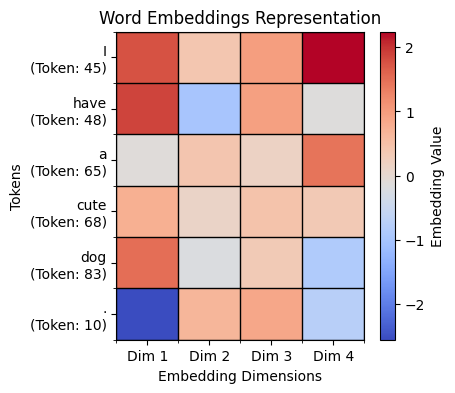

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Sample sentence and tokenization (simple integer mapping)
sentence = ["I", "have", "a", "cute", "dog", "."]
token_ids = np.array([45, 48, 65, 68, 83, 10])

# Simulated embeddings (each word mapped to a 4-dimensional vector)
embedding_dim = 4
np.random.seed(0)  # For reproducibility
embeddings = np.random.randn(len(token_ids), embedding_dim)

# Plotting
fig, ax = plt.subplots(figsize=(4, 4))
cax = ax.imshow(embeddings, cmap="coolwarm", aspect="auto")

# Labels for words and tokens
ax.set_xticks(range(embedding_dim))
ax.set_xticklabels([f"Dim {i+1}" for i in range(embedding_dim)], fontsize=10)
ax.set_yticks(range(len(sentence)))
ax.set_yticklabels([f"{word}\n(Token: {tid})" for word, tid in zip(sentence, token_ids)], fontsize=10)

# Add grid to emphasize separation between dimensions and words
ax.set_xticks(np.arange(-0.5, embedding_dim, 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(sentence), 1), minor=True)
ax.grid(visible=True, which="minor", color="black", linewidth=1.0, linestyle="-")

# Title and labels
ax.set_title("Word Embeddings Representation", fontsize=12)
ax.set_xlabel("Embedding Dimensions", fontsize=10)
ax.set_ylabel("Tokens", fontsize=10)

# Add colorbar
plt.colorbar(cax, label="Embedding Value")

# Display
plt.show()

We have the sentence "*I have a cute dog.*" . It is tokenized as $\left[\text{"I"} + \text{"have"} + \text{"a"} + \text{"cute"} + \text{"dog"} + \text{"."}\right]$. Each of the tokens are assigned an integer that is totally random except for being unique to that token. After the embedding, these are all covnerted to vectors of size 4.

### Positional Encoding

The main strength of the transformers come from their ability to do parallel processing of a sequence unlike the previous RNNs and LSTMs. However, word ordering is still important within a sentence and hence positional information must be stored in some way. In transformers, this is done by a rule-based (i.e. not trainable), addition based operation where the added functions are sinusoids as;

$$
\text{PE}(x, i) = \sin\left(\frac{x}{10000^{i/d_{\text{model}}}}\right), \quad \text{for even } i \\
\text{PE}(x, i) = \cos\left(\frac{x}{10000^{(i-1)/d_{\text{model}}}}\right), \quad \text{for odd } i
$$

This way the unique position information can be given without changing the vector size $d_{\text{model}}$ and subsequent parallel processing steps can be applied appropriately.

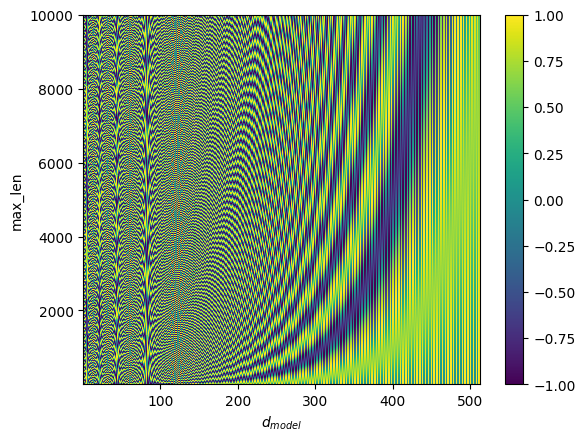

In [ ]:
import torch
import math
import matplotlib.pyplot as plt
import numpy as np

d_model=512; max_len=10000

pe = torch.zeros(max_len, d_model)
position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

pe[:, 0:d_model:2] = torch.sin(position / 10000**(torch.arange(0,d_model,2) / d_model))
pe[:, 1:d_model:2] = torch.cos(position / 10000**(torch.arange(0,d_model,2) / d_model))

# Define the 2D domain
x = np.linspace(1, d_model, d_model)
y = np.linspace(1, max_len, max_len)
X, Y = np.meshgrid(x, y)

plt.pcolormesh(X, Y, pe, cmap='viridis', shading='auto')
plt.colorbar()
plt.xlabel("$d_{model}$")
plt.ylabel("max_len")
plt.show()

### Attention

Before discussing the mathematical representation, it is important to first understand *what* attention means. A simple way to think about it is how we naturally focus on key parts of information. For example, when listening to a conversation, we tend to catch important words while ignoring less relevant ones. This selective focus allows us to process information efficiently.

Similarly, attention in deep learning assigns importance to different parts of an input. Not every word in a sentence or every pixel in an image contributes equally to comprehension. When looking at a portrait, for instance, we instinctively focus on the subject rather than the background. In the same way, attention mechanism dynamically adjusts focus, emphasizing relevant features while de-emphasizing others.

In the attention mechanism used in transformers, there are three key components: Query ($Q$), Key ($K$), and Value ($V$). Their names may seem abstract, but we can understand them through a simple analogy.

Imagine you have a specific question ($Q$) you need to answer. To find relevant information, you turn to a library full of books. However, reading every book would take too long, so instead, you first scan the catalog for books whose titles and descriptions ($K$) match your question ($Q$). The better the match, the more likely that book contains useful information. However, one cannot be sure until reading the books.

Once you identify the most relevant books, you then read their actual contents ($V$) to extract useful information. In attention, the dot product between Q and K determines how well each book matches the question, and this relevance score is used to weight the importance of each book's content ($V$). The result is a weighted sum of the most relevant information, allowing the model to focus on the most useful parts of the input.

The basic premise of the attention comes from its ability for faster processing. Unlike RNNs that process words sequentially, attention enables parallel processing by allowing each token to focus on relevant words in the input. Let's now discuss the inner parts of the attention mechanism. Call the predecessors of $Q$, $K$, $V$ signals $x_Q$, $x_K$, $x_V$ (these can be the same signals or not as we will see in self-attention and cross attention cases). They will be passed through linear layers $W_Q$, $W_K$, $W_V$.

$$
Q=W_Q x_Q, \quad K=W_K x_K, \quad V=W_V x_V
$$

The outputs of these linear layers are of size $(l_{\text{seq}} \times d_{\text{model}})$ for each sample. These outputs will then be splitted into $n_\text{head}$ which must be an integer factor of $d_{\text{model}}$, and each will go to a different attention block called an attention head. Each attention head can be considered as a different way of prioritizing the similarity of inputs. One can look at rhyming, the other semantic similarity etc.

Let $i$ showing the index of a particular head, the attention calculation in that head is;

$$
\text{attention}_i(Q_i, K_i, V_i) = \text{softmax} \left( \frac{Q_iK_i^T}{\sqrt{d_K}} \right) V_i \\
$$

where $d_K=d_{\text{model}}/n_\text{head}$ and is the size of each vector in $Q_i$, $K_i$, $V_i$. The $Q_iK_i^T$ operation in the numerator gives a matrix that corresponds to the dot product of each token in $Q_i$ to each token in $K_i$ and they will be normalized to act as probabilities by applying the softmax function. Those probabilities will be multiplied by $V_i$ which holds the necessary features, and more relevant ones will be highlighted more with higher probabilities. At the end, the outputs of the heads will be concataneted and passed through a final output linear layer.

Since the splitting and concatenation operations within the attention block can be confusing, it is beneficial to give the dimensions at each point within the block. I will try to keep them as general as possible. Note that all the signals will have an additional batch dimension normally but it will be dropped here for simplicity. Now let's assume sequence lengths for $Q$ and $K$ signals are $l_{\text{seq},Q}$ and $l_{\text{seq},K}$ respectively; also the vector sizes in signals $K$ and $V$ are $d_{\text{model},K}$ and $d_{\text{model},V}$. Thus, the input streams to the attention block $X_Q$, $X_K$, $X_V$ have dimensions;

$$
X_Q → (l_{\text{seq},Q}, \, d_{\text{model},K}), \quad
X_K → (l_{\text{seq},K}, \, d_{\text{model},K}), \quad
X_V → (l_{\text{seq},K}, \, d_{\text{model},V})
$$

As mentioned, the generality will be taken into account but it can be seen that $X_Q$ and $X_K$ share the vector size and $X_K$ and $X_V$ share the sequence length dimensions. This is because even in the most general case the upcoming matrix operations necessitate the common values here. These signals will be forward passed to the linear layers to create $Q$, $K$, $V$ signals. However, after the linear operation there is also splitting these into multiple attention heads with number $n_\text{head}$. These new dimensions will be;

$$
Q → (n_\text{head}, \, l_{\text{seq},Q}, \, d_K), \quad
K → (n_\text{head}, \, l_{\text{seq},K}, \, d_K), \quad
V → (n_\text{head}, \, l_{\text{seq},K}, \, d_V)
$$

where $d_K=d_{\text{model},K}/n_\text{head}$ and $d_V=d_{\text{model},V}/n_\text{head}$. After that the dot product of each word in $Q$ and $K$ will be taken with the dimensions;

$$
\text{score/dot product}(Q,K) = QK^T → (n_\text{head}, \, l_{\text{seq},Q}, \, l_{\text{seq},K})
$$

This dot product operation is the reason that they have to share the vector size values (i.e. $d_{\text{model},K}$ or $d_K$ in each attention head). This dot product operation will be followed by a scaling and softmax operation which neither will change dimensions. The final attention output after multiplying with $V$ will be;

$$
\text{attention}(Q,K,V) = \text{softmax} \left( \frac{QK^T}{\sqrt{d_K}} \right) V → (n_\text{head}, \, l_{\text{seq},Q}, \, d_V)
$$

There is also a final concatentation of each attention head output. The $n_\text{head}$ dimension will drop and we will have;

$$
\text{concat}(\text{attention}(Q,K,V)) → (l_{\text{seq},Q}, \, d_{\text{model},V})
$$

In the actual transformer implementation the sizes of each vector are same so the last dimension above can be dropped to $d_{\text{model}}$ without using the $V$ index additionally. However, keeping sequence dimensions different is still relevant because they will be different for one attention block used which is the cross-attention block in the decoder.

There are 3 different attention blocks used in transformer architecture: 2 self-attention blocks and 1 cross-attention block. The structure of the blocks are equivalant where the actual difference is about the inputs taken as $Q$, $K$, $V$. They are explained below with toy examples showing the steps in each (except for the scaling operation). Let's examine them:

* **Encoder self-attention block:** All the signals given to the $Q$, $K$, $V$ linear layers are the same and taken either from the encoder embedding outputs or outputs of previous encoder layer (remember we have $N$ encoder layers stacked). This basically highlights the most important words, and downgrades the less relevant ones in the language to be translated.

$$
Q = \begin{bmatrix} 1 & 0 \\ 0 & 1 \\ 1 & 1 \\ 2 & 0\end{bmatrix}, \quad
K = \begin{bmatrix} 0 & 1 \\ 1 & 0 \\ 2 & 1 \\ 1 & 2 \end{bmatrix}, \quad
V = \begin{bmatrix} 1 & 2 \\ 2 & 3 \\ 3 & 1 \\ 0 & 2 \end{bmatrix}
$$

$$
QK^T = \begin{bmatrix} 0 & 1 & 2 & 1 \\ 1 & 0 & 1 & 2 \\ 1 & 1 & 3 & 3 \\ 0 & 2 & 4 & 2 \\ \end{bmatrix}, \quad
\text{Softmax}(QK^T) = \begin{bmatrix} 0.07 & 0.2 & 0.53 & 0.2 \\ 0.2 & 0.07 & 0.2 & 0.53 \\ 0.06 & 0.06 & 0.44 & 0.44 \\ 0.01 & 0.1 & 0.78 & 0.1 \\ \end{bmatrix}
$$


$$
\text{Final Output} = \text{Softmax}(QK^T) \cdot V = \begin{bmatrix} 2.07 & 1.66\\ 0.93 & 1.88\\ 1.5 & 1.62 \\ 2.55 & 1.33 \end{bmatrix}
$$

* **Decoder self-attention block:** This is similar to encoder self-attention block taking their input streams from decoder related equivalents this time. One important distinction from encoder attention is the usage of a causal mask. Decoders in a transformer are typically used for the task of next word prediction given all the words decoded up to that point, thus instead of calculating relevance of all words with each other, a word relevance is calculated for only the words coming before it. For this reason, unlike the attention matrix of encoder block, it will have a lower triangular structure.

In the below example the sequence dimension is 1 less than the encoder case since the input to the decoder is given by removing the last token of the target sequence in order to encourage for next word prediction.

$$
Q = \begin{bmatrix} 1 & 1 \\ 0 & 2 \\ 2 & 0\end{bmatrix}, \quad
K = \begin{bmatrix} 1 & 0 \\ 0 & 1 \\ 2 & 1 \end{bmatrix}, \quad
V = \begin{bmatrix} 2 & 1 \\ 1 & 3 \\ 3 & 2 \end{bmatrix}
$$

$$
QK^T = \begin{bmatrix} 1 & 1 & 3 \\ 0 & 2 & 2 \\ 2 & 0 & 4 \end{bmatrix}, \quad
\text{Mask}(QK^T) = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 2 & 0 \\ 2 & 0 & 4 \end{bmatrix} \quad
\text{Softmax}(\text{Mask}(QK^T)) = \begin{bmatrix} 0.58 & 0.21 & 0.21 \\ 0.1 & 0.79 & 0.11 \\ 0.12 & 0.02 & 0.87 \end{bmatrix}
$$

$$
\text{Final Output} = \text{Softmax}(QK^T) \cdot V = \begin{bmatrix} 2 & 1.64\\ 1.32 & 2.68\\ 2.85 & 1.9 \end{bmatrix}
$$

* **Decoder cross-attention block:** This is the block where the information obtained from encoder and decoder processing are combined to make correspondences between two sequences (like two languages in a translation task). The query is obtained from the decoder self attention block and the keys and values are obtained from the encoder self attention block. This means that it emphasizes the general contextual meaning of the next word to be predicted without resorting any of the languages used here. It will just have a really good grasp of the meaning to be reprsented rather than the word corresponding to that meaning. Once we put it to the final softmax layer outside of the decoder it will give the most probability to the word closest in meaning in the vocabulary of language to be translated.

The below example is mostly similar to encoder self-attention case. The main difference is the difference between the dimension of the $Q$ matrix which is coming from the decoder and $K$, $V$ matrices which are coming from the encoder.

$$
Q = \begin{bmatrix} 2 & 1 \\ 1 & 2 \\ 0 & 1 \end{bmatrix}, \quad
K = \begin{bmatrix} 1 & 1 \\ 2 & 0 \\ 0 & 2 \\ 1 & 3 \end{bmatrix}, \quad
V = \begin{bmatrix} 3 & 1 \\ 2 & 2 \\ 1 & 3 \\ 0 & 1 \end{bmatrix}
$$

$$
QK^T = \begin{bmatrix} 3 & 4 & 2 & 5 \\ 3 & 2 & 4 & 7 \\ 1 & 0 & 2 & 3 \end{bmatrix}, \quad
\text{Softmax}(QK^T) = \begin{bmatrix} 0.09 & 0.24 & 0.03 & 0.64 \\ 0.02 & 0.01 & 0.05 & 0.93 \\ 0.09 & 0.03 & 0.24 & 0.64 \end{bmatrix}
$$


$$
\text{Final Output} = \text{Softmax}(QK^T) \cdot V = \begin{bmatrix} 0.77 & 1.3\\ 0.11 & 1.1\\ 0.56 & 1.51 \\ 2.55 & 1.33 \end{bmatrix}
$$

Below is an example of how a cross attention between an English sentence and its French translation may look like.

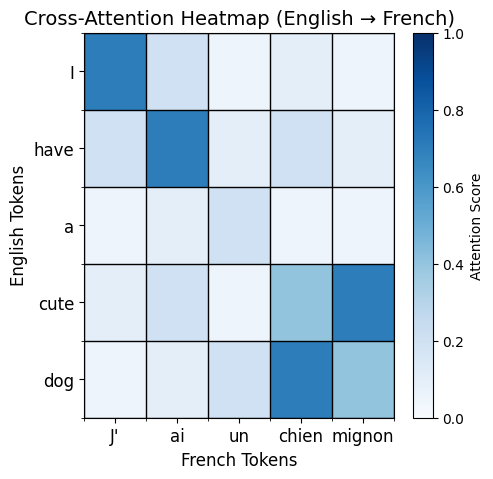

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Updated example sentences
english_sentence = ["I", "have", "a", "cute", "dog"]
french_sentence = ["J'", "ai", "un", "chien", "mignon"]

# Improved manually assigned attention scores
attention_scores = np.array([
    [0.7, 0.2, 0.05, 0.1, 0.05],  # "I" mostly aligns with "J'"
    [0.2, 0.7, 0.1, 0.2, 0.1],    # "have" aligns with "ai"
    [0.05, 0.1, 0.2, 0.05, 0.05], # "a" weakly aligns with "un"
    [0.1, 0.2, 0.05, 0.4, 0.7],   # "cute" aligns with "mignon"
    [0.05, 0.1, 0.2, 0.7, 0.4]    # "dog" aligns with "chien"
])

# Plot heatmap
fig, ax = plt.subplots(figsize=(5,5))
cax = ax.imshow(attention_scores, cmap="Blues", aspect="auto", vmin=0, vmax=1)

# Labels
ax.set_xticks(range(len(french_sentence)))
ax.set_xticklabels(french_sentence, fontsize=12)
ax.set_yticks(range(len(english_sentence)))
ax.set_yticklabels(english_sentence, fontsize=12)

# Add grid to separate words instead of overlaying them
ax.set_xticks(np.arange(-0.5, len(french_sentence), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(english_sentence), 1), minor=True)
ax.grid(visible=True, which="minor", color="black", linewidth=1.0, linestyle="-")

# Title and axis labels
ax.set_title("Cross-Attention Heatmap (English → French)", fontsize=14)
ax.set_xlabel("French Tokens", fontsize=12)
ax.set_ylabel("English Tokens", fontsize=12)

# Add colorbar
plt.colorbar(cax, label="Attention Score")

# Display
plt.show()

A possible cross attention weight for the English sentence "*I have a cute dog.*" and its French translation "*J'ai un chien mignon.*" is given above. The scores that correspond to direct counterparts of the words have a tendency to have higher attention scores. Note that this does not necessarily mean high values diagonally because different languages can have different orderings which is indeed the case above where *dog* in French is *chien* and *cute* in French is *mignon* and they switch places in different languages.

The words that contribute more to the context also have tendency for higher attention weights which is the main purpose of using attention to begin with. This generally means very common words like "I", "the", "is" often have lower attention weights because they rarely makes a significant difference to overall sentence meaning (but not always, everything is contextual). For the above sentence, the most attentive words can be the "dog" and its feature of being "cute".

### Residual Connections and Positionwise Feedforward Networks

There are also two additional mechanisms that are complementary but crucial for transformer functionality. Although not shown in the initial diagram, a residual connection follows each block, connecting its input and output. Since transformers stack multiple layers, residual connections reduce information loss by preventing vanishing gradients and help gradients flow through deep networks, improving stability.

Another key mechanism is the positionwise feedforward networks, which come after the encoder self-attention and decoder cross-attention blocks. Unlike attention, these networks process each word independently, applying basic neural network layers to refine representations. These are simple, fully connected networks, but they are the actual feature generators in transformers.

What makes transformers remarkable is that sequential data, which was traditionally processed using RNNs and LSTMs, can now be handled by these simpler feedforward networks. This is possible only because attention assigns importance to tokens, allowing the model to effectively capture relationships without recurrence—hence the title of the paper, Attention is All You Need.

## Implementation

An implementation of the discussed transformer structure is given below. The default values have been used as in the [Attention Is All You Need](https:/arxiv.org/abs/1706.03762) paper. Two different trainings are done with this architecture: One with an artificial data with randomly generated tokens and the other is an English-to-French translator trained on 100 sentences.

For the trainings, the Adam optimizer parameters $\beta_1$, $\beta_2$ and $ϵ$ are also used as in the paper. The learning rate regime starting linearly and decreasing thereafter, is not applied here and a constant learning rate is used. The convergence speed control is left to Adam optimization. Label smoothing is not applied since the results are still satisfactory with the absence of it and it would make the code a little more complex.

One additional thing that was not mentioned explicitly in the paper, but is very common in transformer implementations, is Xavier initialization. A method `init_params` has been implemented in the Transformer class but its call is de-commented in the initialization since better results are obtained in the translation task without it.



In [ ]:
!pip install datasets
!pip install torch==2.2.0 torchtext==0.17.0

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

import torch.nn.functional as F

from tqdm import tqdm

import torch
import numpy as np
import random

def set_random_seed(seed=0):
    """Sets the random seed for PyTorch, NumPy, and Python's random module."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # If using multiple GPUs
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_random_seed(0)

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, max_len=50, d_model=512, num_heads=8, num_layers=6, d_ff=2048, dropout=0.1):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)

        self.encoder = Encoder(d_model, num_heads, d_ff, dropout, num_layers)
        self.decoder = Decoder(d_model, num_heads, d_ff, dropout, num_layers)

        self.linear = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

        self.d_model = d_model

        # self.init_params()

    def encode(self, src, src_mask):
        embedded_src = self.encoder_embedding(src) * math.sqrt(self.d_model)
        pos_encoded_src = self.positional_encoding(embedded_src)
        return self.dropout(self.encoder(pos_encoded_src, src_mask))

    def decode(self, enc_output, src_mask, tgt, tgt_mask):
        embedded_tgt = self.decoder_embedding(tgt) * math.sqrt(self.d_model)
        pos_encoded_tgt = self.positional_encoding(embedded_tgt)
        return self.dropout(self.decoder(pos_encoded_tgt, enc_output, src_mask, tgt_mask))

    def forward(self, src, tgt, src_mask, tgt_mask):
        # return F.softmax(self.linear(self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)), dim=-1)
        return self.linear(self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask))

    def init_params(self):
        for name, p in self.named_parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

class Encoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout, num_layers):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return x

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class Decoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout, num_layers):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

    def forward(self, x, enc_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, enc_output, src_mask, tgt_mask)
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.QKV_linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])

        self.out_linear = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V, mask=None):

        batch_size = Q.shape[0]

        def transform(x, linear):
            x = linear(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
            return x

        Q, K, V = map(lambda x, l: transform(x, l), (Q, K, V), self.QKV_linear_layers)

        # Scaled dot product attention
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_output = torch.matmul(attn_weights, V)

        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.out_linear(attn_output)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        pe[:, 0:d_model:2] = torch.sin(position / 10000**(torch.arange(0,d_model,2) / d_model))
        pe[:, 1:d_model:2] = torch.cos(position / 10000**(torch.arange(0,d_model,2) / d_model))

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

## Artificial Dataset

In this section a training of sequence data is done where both the source and target sequences are randomly generated integers. This is in order to demonstrate that arbitrary sequences can be converted into each other with this architecture. The reduction of the loss shows that and it happens rather fast thanks to the proper selection of hyperparameters, as well. Note that the used loss function is the cross entropy loss which is normally used with softmax predictions. However, if you check the architecture above the forward method of the Transformer class has a linear layer at the end instead of softmax. The reason this works despite this is an implementation detail of PyTorch, which can be checked [here](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), where the nn.CrossEntropyLoss() function handles this itself. This is an implementation detail but an important one that will give suboptimal results if discarded.

In [2]:
set_random_seed(0)

vocab_size_src = 100
vocab_size_tgt = 100

MODEL_DIM = 512
NO_HEADS = 8
NO_LAYERS = 6
FF_DIM = 2048
DROPOUT_RATE = 0.1

MAX_SEQ_LEN = 20
BATCH_SIZE=100

model = Transformer(vocab_size_src, vocab_size_tgt, max_len=MAX_SEQ_LEN, d_model=MODEL_DIM, num_heads=NO_HEADS, num_layers=NO_LAYERS, d_ff=FF_DIM, dropout=DROPOUT_RATE)

# Generate random sample data as tokens
src_data = torch.randint(0, vocab_size_src-1, (BATCH_SIZE, MAX_SEQ_LEN))
tgt_data = torch.randint(0, vocab_size_tgt-1, (BATCH_SIZE, MAX_SEQ_LEN))

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

for epoch in tqdm(range(100)):
    model.train()
    optimizer.zero_grad()

    # Create masks (assume 0 is the pad token id)
    src_mask = (src_data != 0).unsqueeze(1).unsqueeze(2)
    tgt_mask = (tgt_data[:, :-1] != 0).unsqueeze(1).unsqueeze(3)
    causal_mask = torch.triu(torch.ones((1, tgt_data[:, :-1].size(1), tgt_data[:, :-1].size(1))) == 1).transpose(1,2)
    tgt_mask = tgt_mask & causal_mask

    output = model(src_data, tgt_data[:, :-1], src_mask, tgt_mask)
    loss = criterion(output.contiguous().view(-1, vocab_size_tgt), tgt_data[:, 1:].contiguous().view(-1))
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

  1%|          | 1/100 [00:22<37:37, 22.80s/it]

Epoch: 1, Loss: 4.810876846313477


  2%|▏         | 2/100 [00:37<29:27, 18.04s/it]

Epoch: 2, Loss: 4.63302755355835


  3%|▎         | 3/100 [00:55<29:25, 18.20s/it]

Epoch: 3, Loss: 4.4814887046813965


  4%|▍         | 4/100 [01:09<26:00, 16.25s/it]

Epoch: 4, Loss: 4.3813300132751465


  5%|▌         | 5/100 [01:22<24:02, 15.19s/it]

Epoch: 5, Loss: 4.2658514976501465


  6%|▌         | 6/100 [01:35<22:45, 14.53s/it]

Epoch: 6, Loss: 4.101536273956299


  7%|▋         | 7/100 [01:49<22:02, 14.22s/it]

Epoch: 7, Loss: 3.928900718688965


  8%|▊         | 8/100 [02:03<21:36, 14.09s/it]

Epoch: 8, Loss: 3.7752439975738525


  9%|▉         | 9/100 [02:16<20:55, 13.80s/it]

Epoch: 9, Loss: 3.6214897632598877


 10%|█         | 10/100 [02:29<20:19, 13.55s/it]

Epoch: 10, Loss: 3.4973337650299072


 11%|█         | 11/100 [02:42<19:48, 13.35s/it]

Epoch: 11, Loss: 3.373307228088379


 12%|█▏        | 12/100 [02:55<19:21, 13.20s/it]

Epoch: 12, Loss: 3.241215229034424


 13%|█▎        | 13/100 [03:09<19:46, 13.64s/it]

Epoch: 13, Loss: 3.1243185997009277


 14%|█▍        | 14/100 [03:23<19:28, 13.59s/it]

Epoch: 14, Loss: 3.0147063732147217


 15%|█▌        | 15/100 [03:36<19:05, 13.48s/it]

Epoch: 15, Loss: 2.903735876083374


 16%|█▌        | 16/100 [03:49<18:47, 13.43s/it]

Epoch: 16, Loss: 2.7913129329681396


 17%|█▋        | 17/100 [04:02<18:23, 13.29s/it]

Epoch: 17, Loss: 2.6794674396514893


 18%|█▊        | 18/100 [04:15<18:06, 13.25s/it]

Epoch: 18, Loss: 2.59013032913208


 19%|█▉        | 19/100 [04:29<17:53, 13.26s/it]

Epoch: 19, Loss: 2.4848170280456543


 20%|██        | 20/100 [04:42<17:44, 13.30s/it]

Epoch: 20, Loss: 2.40543794631958


 21%|██        | 21/100 [04:55<17:32, 13.32s/it]

Epoch: 21, Loss: 2.3153469562530518


 22%|██▏       | 22/100 [05:09<17:20, 13.34s/it]

Epoch: 22, Loss: 2.218590021133423


 23%|██▎       | 23/100 [05:22<17:08, 13.35s/it]

Epoch: 23, Loss: 2.1245110034942627


 24%|██▍       | 24/100 [05:36<17:02, 13.45s/it]

Epoch: 24, Loss: 2.042372226715088


 25%|██▌       | 25/100 [05:49<16:48, 13.45s/it]

Epoch: 25, Loss: 1.968860149383545


 26%|██▌       | 26/100 [06:03<16:34, 13.44s/it]

Epoch: 26, Loss: 1.885792851448059


 27%|██▋       | 27/100 [06:16<16:23, 13.48s/it]

Epoch: 27, Loss: 1.8132930994033813


 28%|██▊       | 28/100 [06:30<16:11, 13.49s/it]

Epoch: 28, Loss: 1.738938808441162


 29%|██▉       | 29/100 [06:43<15:54, 13.45s/it]

Epoch: 29, Loss: 1.6536290645599365


 30%|███       | 30/100 [06:56<15:35, 13.37s/it]

Epoch: 30, Loss: 1.5989434719085693


 31%|███       | 31/100 [07:09<15:18, 13.30s/it]

Epoch: 31, Loss: 1.5228033065795898


 32%|███▏      | 32/100 [07:23<15:00, 13.24s/it]

Epoch: 32, Loss: 1.4461610317230225


 33%|███▎      | 33/100 [07:36<14:46, 13.24s/it]

Epoch: 33, Loss: 1.3900619745254517


 34%|███▍      | 34/100 [07:49<14:38, 13.30s/it]

Epoch: 34, Loss: 1.3131791353225708


 35%|███▌      | 35/100 [08:03<14:27, 13.34s/it]

Epoch: 35, Loss: 1.2478598356246948


 36%|███▌      | 36/100 [08:16<14:15, 13.37s/it]

Epoch: 36, Loss: 1.1910749673843384


 37%|███▋      | 37/100 [08:29<13:59, 13.33s/it]

Epoch: 37, Loss: 1.122236967086792


 38%|███▊      | 38/100 [08:42<13:42, 13.26s/it]

Epoch: 38, Loss: 1.064737319946289


 39%|███▉      | 39/100 [08:56<13:26, 13.21s/it]

Epoch: 39, Loss: 1.018386721611023


 40%|████      | 40/100 [09:09<13:14, 13.25s/it]

Epoch: 40, Loss: 0.9557929039001465


 41%|████      | 41/100 [09:22<13:06, 13.33s/it]

Epoch: 41, Loss: 0.9025037288665771


 42%|████▏     | 42/100 [09:36<12:55, 13.37s/it]

Epoch: 42, Loss: 0.8514138460159302


 43%|████▎     | 43/100 [09:49<12:43, 13.40s/it]

Epoch: 43, Loss: 0.8027777671813965


 44%|████▍     | 44/100 [10:03<12:31, 13.43s/it]

Epoch: 44, Loss: 0.7588379979133606


 45%|████▌     | 45/100 [10:16<12:19, 13.45s/it]

Epoch: 45, Loss: 0.7055409550666809


 46%|████▌     | 46/100 [10:30<12:07, 13.47s/it]

Epoch: 46, Loss: 0.6676954030990601


 47%|████▋     | 47/100 [10:43<11:54, 13.49s/it]

Epoch: 47, Loss: 0.6217801570892334


 48%|████▊     | 48/100 [11:03<13:21, 15.42s/it]

Epoch: 48, Loss: 0.5860575437545776


 49%|████▉     | 49/100 [11:17<12:37, 14.86s/it]

Epoch: 49, Loss: 0.5436747074127197


 50%|█████     | 50/100 [11:30<12:00, 14.40s/it]

Epoch: 50, Loss: 0.5070327520370483


 51%|█████     | 51/100 [11:43<11:26, 14.01s/it]

Epoch: 51, Loss: 0.4733402729034424


 52%|█████▏    | 52/100 [11:56<10:59, 13.73s/it]

Epoch: 52, Loss: 0.44285786151885986


 53%|█████▎    | 53/100 [12:10<10:40, 13.62s/it]

Epoch: 53, Loss: 0.42178913950920105


 54%|█████▍    | 54/100 [12:23<10:26, 13.61s/it]

Epoch: 54, Loss: 0.39196810126304626


 55%|█████▌    | 55/100 [12:37<10:11, 13.59s/it]

Epoch: 55, Loss: 0.36231425404548645


 56%|█████▌    | 56/100 [12:50<09:57, 13.59s/it]

Epoch: 56, Loss: 0.3420626223087311


 57%|█████▋    | 57/100 [13:04<09:43, 13.57s/it]

Epoch: 57, Loss: 0.31609758734703064


 58%|█████▊    | 58/100 [13:17<09:29, 13.56s/it]

Epoch: 58, Loss: 0.294557124376297


 59%|█████▉    | 59/100 [13:31<09:14, 13.53s/it]

Epoch: 59, Loss: 0.280326783657074


 60%|██████    | 60/100 [13:44<09:01, 13.54s/it]

Epoch: 60, Loss: 0.26170814037323


 61%|██████    | 61/100 [13:58<08:48, 13.56s/it]

Epoch: 61, Loss: 0.2431379109621048


 62%|██████▏   | 62/100 [14:12<08:34, 13.53s/it]

Epoch: 62, Loss: 0.23039041459560394


 63%|██████▎   | 63/100 [14:25<08:18, 13.47s/it]

Epoch: 63, Loss: 0.21494388580322266


 64%|██████▍   | 64/100 [14:38<08:02, 13.39s/it]

Epoch: 64, Loss: 0.2030162215232849


 65%|██████▌   | 65/100 [14:51<07:44, 13.28s/it]

Epoch: 65, Loss: 0.19173194468021393


 66%|██████▌   | 66/100 [15:04<07:30, 13.24s/it]

Epoch: 66, Loss: 0.18155540525913239


 67%|██████▋   | 67/100 [15:18<07:18, 13.28s/it]

Epoch: 67, Loss: 0.16768504679203033


 68%|██████▊   | 68/100 [15:31<07:07, 13.35s/it]

Epoch: 68, Loss: 0.16015125811100006


 69%|██████▉   | 69/100 [15:45<06:55, 13.41s/it]

Epoch: 69, Loss: 0.15263226628303528


 70%|███████   | 70/100 [15:58<06:41, 13.37s/it]

Epoch: 70, Loss: 0.14599479734897614


 71%|███████   | 71/100 [16:11<06:25, 13.30s/it]

Epoch: 71, Loss: 0.13482968509197235


 72%|███████▏  | 72/100 [16:24<06:11, 13.26s/it]

Epoch: 72, Loss: 0.1316952258348465


 73%|███████▎  | 73/100 [16:38<05:58, 13.27s/it]

Epoch: 73, Loss: 0.12297666072845459


 74%|███████▍  | 74/100 [16:51<05:46, 13.32s/it]

Epoch: 74, Loss: 0.11846420168876648


 75%|███████▌  | 75/100 [17:04<05:34, 13.37s/it]

Epoch: 75, Loss: 0.11317071318626404


 76%|███████▌  | 76/100 [17:18<05:22, 13.44s/it]

Epoch: 76, Loss: 0.10741721093654633


 77%|███████▋  | 77/100 [17:32<05:09, 13.46s/it]

Epoch: 77, Loss: 0.10600672662258148


 78%|███████▊  | 78/100 [17:45<04:58, 13.56s/it]

Epoch: 78, Loss: 0.09987127780914307


 79%|███████▉  | 79/100 [17:59<04:44, 13.53s/it]

Epoch: 79, Loss: 0.09628282487392426


 80%|████████  | 80/100 [18:12<04:30, 13.52s/it]

Epoch: 80, Loss: 0.09134292602539062


 81%|████████  | 81/100 [18:26<04:17, 13.56s/it]

Epoch: 81, Loss: 0.08837255090475082


 82%|████████▏ | 82/100 [18:40<04:03, 13.55s/it]

Epoch: 82, Loss: 0.0860665887594223


 83%|████████▎ | 83/100 [18:53<03:49, 13.51s/it]

Epoch: 83, Loss: 0.08093388378620148


 84%|████████▍ | 84/100 [19:06<03:33, 13.37s/it]

Epoch: 84, Loss: 0.07564927637577057


 85%|████████▌ | 85/100 [19:19<03:19, 13.28s/it]

Epoch: 85, Loss: 0.0756174772977829


 86%|████████▌ | 86/100 [19:32<03:06, 13.30s/it]

Epoch: 86, Loss: 0.07243143022060394


 87%|████████▋ | 87/100 [19:46<02:53, 13.36s/it]

Epoch: 87, Loss: 0.06997945159673691


 88%|████████▊ | 88/100 [19:59<02:40, 13.41s/it]

Epoch: 88, Loss: 0.06841649115085602


 89%|████████▉ | 89/100 [20:13<02:27, 13.42s/it]

Epoch: 89, Loss: 0.06718797981739044


 90%|█████████ | 90/100 [20:26<02:13, 13.35s/it]

Epoch: 90, Loss: 0.06585714221000671


 91%|█████████ | 91/100 [20:39<01:59, 13.28s/it]

Epoch: 91, Loss: 0.06339433044195175


 92%|█████████▏| 92/100 [20:52<01:46, 13.29s/it]

Epoch: 92, Loss: 0.06190241500735283


 93%|█████████▎| 93/100 [21:10<01:42, 14.57s/it]

Epoch: 93, Loss: 0.06054806709289551


 94%|█████████▍| 94/100 [21:24<01:25, 14.27s/it]

Epoch: 94, Loss: 0.05743103101849556


 95%|█████████▌| 95/100 [21:39<01:13, 14.68s/it]

Epoch: 95, Loss: 0.05481305345892906


 96%|█████████▌| 96/100 [21:53<00:57, 14.35s/it]

Epoch: 96, Loss: 0.05493505671620369


 97%|█████████▋| 97/100 [22:06<00:42, 14.13s/it]

Epoch: 97, Loss: 0.053130682557821274


 98%|█████████▊| 98/100 [22:20<00:28, 14.01s/it]

Epoch: 98, Loss: 0.05253991857171059


 99%|█████████▉| 99/100 [22:34<00:13, 13.84s/it]

Epoch: 99, Loss: 0.050454363226890564


100%|██████████| 100/100 [22:47<00:00, 13.67s/it]

Epoch: 100, Loss: 0.04911864548921585


## Real Language Dataset

The above training with the artificial dataset was in order to show the functionality of the transformer but it will be more fun to see it in an actual translation application. This section trains an English-to-French translator using the same architecture (and mostly same hyperparameters) as the artificial dataset case. In order to keep the training short, only 100 sentences have been used which is obviously not sufficient for a real translator but it is nice to make a demonstration nonetheless. While evaluation metrics like BLEU exist, it is not included here. Since our focus is on understanding transformer mechanisms rather than translation evaluation. Moreover, BLEU is a little more complicated than metrics used in other machine learning tasks because unlike those tasks, language translation does not have a unique ground truth and BLEU is designed considering this fact. It deserves its own tutorial, so it will be discarded here.

In [ ]:
!python -m spacy download fr_core_news_sm
!python -m spacy download en_core_web_sm

In [4]:
SOS_TOKEN = '<SOS>'
EOS_TOKEN = '<EOS>'
UNK_TOKEN = '<UNK>'
PAD_TOKEN = '<PAD>'

MODEL_DIM = 512
NO_HEADS = 8
NO_LAYERS = 6
FF_DIM = 2048
DROPOUT_RATE = 0.1

MAX_SEQ_LEN = 50

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import numpy as np
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
import datasets

from tqdm import tqdm

set_random_seed(0)

def load_dataset(num_samples=None):
    dataset = datasets.load_dataset('iwslt2017', 'iwslt2017-en-fr', trust_remote_code=True)
    if num_samples:
        return dataset['train'].select(range(num_samples))
    return dataset['train']

def tokenize_data(dataset):
    tokenizer_en = get_tokenizer('spacy', language='en_core_web_sm')
    tokenizer_fr = get_tokenizer('spacy', language='fr_core_news_sm')

    def yield_tokens(data_iter, tokenizer, lang):
        for example in tqdm(data_iter):
            yield tokenizer(example['translation'][lang])

    vocab_en = build_vocab_from_iterator(yield_tokens(dataset, tokenizer_en, 'en'), specials=[SOS_TOKEN, EOS_TOKEN, UNK_TOKEN, PAD_TOKEN])
    vocab_fr = build_vocab_from_iterator(yield_tokens(dataset, tokenizer_fr, 'fr'), specials=[SOS_TOKEN, EOS_TOKEN, UNK_TOKEN, PAD_TOKEN])

    vocab_en.set_default_index(vocab_en[UNK_TOKEN])
    vocab_fr.set_default_index(vocab_fr[UNK_TOKEN])
    return vocab_en, vocab_fr

class TranslationDataset(Dataset):
    def __init__(self, dataset, vocab_en, vocab_fr, tokenizer_en, tokenizer_fr, max_length=50):
        self.dataset = dataset
        self.vocab_en = vocab_en
        self.vocab_fr = vocab_fr
        self.tokenizer_en = tokenizer_en
        self.tokenizer_fr = tokenizer_fr
        self.max_length = max_length

    def encode_sentence(self, sentence, vocab, tokenizer):
        tokens = tokenizer(sentence)
        token_ids = [vocab[SOS_TOKEN]] + [vocab[token] if token in vocab else vocab[UNK_TOKEN] for token in tokens] + [vocab[EOS_TOKEN]]
        return token_ids[:self.max_length] + [vocab[PAD_TOKEN]] * (self.max_length - len(token_ids))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        src_text = self.dataset[idx]['translation']['en']
        tgt_text = self.dataset[idx]['translation']['fr']
        src_ids = torch.tensor(self.encode_sentence(src_text, self.vocab_en, self.tokenizer_en))
        tgt_ids = torch.tensor(self.encode_sentence(tgt_text, self.vocab_fr, self.tokenizer_fr))
        return src_ids, tgt_ids, src_text, tgt_text

In [6]:
set_random_seed(0)

# Prepare dataset
data = load_dataset(num_samples=100)
vocab_en, vocab_fr = tokenize_data(data)
vocab_size_en, vocab_size_fr = len(vocab_en), len(vocab_fr)

# Create dataset and dataloader
tokenizer_en = get_tokenizer('spacy', language='en_core_web_sm')
tokenizer_fr = get_tokenizer('spacy', language='fr_core_news_sm')
train_dataset = TranslationDataset(data, vocab_en, vocab_fr, tokenizer_en, tokenizer_fr, max_length=MAX_SEQ_LEN)
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

iwslt2017.py:   0%|          | 0.00/8.17k [00:00<?, ?B/s]

en-fr.zip:   0%|          | 0.00/27.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/232825 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8597 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/890 [00:00<?, ? examples/s]

100%|██████████| 100/100 [00:00<00:00, 1294.52it/s]


One crucial step in the translation task is how the words in the final sentence will be decided. The transformer output will give us word probabilities but how to handle these probabilities is another task within itself which is called *decoding* (not same as the function of the transformer decoder but related).

We know that transformer has two inputs where one is the encoder source sentence and the other decoder autoregressive target sentence translated up to that point. The decoder input part should be invisible to an outside user who can only see the source language sentence that is desired to be translated. The translation will be done as follows:

* The vectorized source language sentence will be processed in the encoder all at once and its latent representation is obtained.
* The start token will be given as input to the decoder (this part is invisible to user).
* Based on the encoder output and start token as input to the decoder a probability distribution for the first word will be obtained at the decoder output.
* This prediction of the probabilities of next words will be continued until a stop token is generated. At this point, we have a sequence of probabilities.
* Based on the decoding method at each position the highest probability token can be given as output (greedy decoding) or an output may be generated based on the joint probability of consecutive tokens (beam search).

These two methods both have their pros and cons. Greedy decoding is faster and can be applied real time, while beam search has some associated delay both because it has to wait for the probabilities of a group of words to make a decision and also the additional processing to compute the probabilities of word groups. The advantage is that beam search naturally gives better outputs since it takes into account the relation between the words while greedy decoding can be suboptimal.

In [14]:
# Greedy Decoding Function
def greedy_decode(model, src, max_len, start_symbol, vocab_src, vocab_tgt):
    model.eval()
    with torch.no_grad():
        # Get encoder output of source sentence.
        src_mask = (src != vocab_src[PAD_TOKEN]).unsqueeze(1).unsqueeze(2)
        enc_output = model.encode(src, src_mask)

        # Calculate next word probabilities for target sentence until the stop token is generated.
        tgt = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data)
        for _ in range(max_len):
            # Get the word probabilities for the next word.
            tgt_mask = (tgt != vocab_tgt[PAD_TOKEN]).unsqueeze(1).unsqueeze(3)
            causal_mask = torch.triu(torch.ones((1, tgt_mask.shape[2], tgt_mask.shape[2])) == 1).transpose(1,2)
            tgt_mask = tgt_mask & causal_mask

            dec_output = model.decode(enc_output, src_mask, tgt,  tgt_mask)
            output = F.softmax(model.linear(dec_output[:, -1]), dim=-1)

            # Greedy decoding, i.e. get the word with highest probabilitiy
            next_word = output.argmax(dim=-1).item()

            tgt = torch.cat([tgt, torch.tensor([[next_word]], device=src.device)], dim=1)

            # If stop token is generated, stop decoding.
            if next_word == vocab_fr[EOS_TOKEN]:
                break

    return tgt.squeeze().tolist()

In [15]:
set_random_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Transformer(vocab_size_en, vocab_size_fr, max_len=MAX_SEQ_LEN, d_model=MODEL_DIM, num_heads=NO_HEADS, num_layers=NO_LAYERS, d_ff=FF_DIM, dropout=DROPOUT_RATE)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

# NO_EPOCHS=100
NO_EPOCHS=50
for epoch in tqdm(range(NO_EPOCHS)):
    model.train()
    for src_ids, tgt_ids, src_text, tgt_text in dataloader:
        optimizer.zero_grad()

        # Create masks
        src_mask = (src_ids != vocab_en[PAD_TOKEN]).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt_ids[:, :-1] != vocab_fr[PAD_TOKEN]).unsqueeze(1).unsqueeze(3)
        causal_mask = torch.triu(torch.ones((1, tgt_ids[:, :-1].size(1), tgt_ids[:, :-1].size(1))) == 1).transpose(1,2)
        tgt_mask = tgt_mask & causal_mask

        output = model(src_ids, tgt_ids[:, :-1], src_mask, tgt_mask)
        loss = criterion(output.contiguous().view(-1, vocab_size_fr), tgt_ids[:, 1:].contiguous().view(-1))
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

    if epoch%5==0 or epoch==NO_EPOCHS-1:
        # Print translations for 10 sentences
        model.eval()
        for i in range(10):
            src_sample = train_dataset[i][0].unsqueeze(0)
            translated_ids = greedy_decode(model, src_sample, max_len=MAX_SEQ_LEN, start_symbol=vocab_fr[SOS_TOKEN], vocab_src=vocab_en, vocab_tgt=vocab_fr)
            # print("Generated IDs:", translated_ids)
            translated_sentence = ' '.join([list(vocab_fr.get_itos())[idx] for idx in translated_ids if idx not in [vocab_fr[SOS_TOKEN], vocab_fr[EOS_TOKEN], vocab_fr[PAD_TOKEN]]])

            tgt_original = train_dataset[i][3]
            print(f"English: {train_dataset[i][2]}")
            print(f"French (Original): {tgt_original}")
            print(f"French (Predicted): {translated_sentence}")
            print("-" * 80)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, Loss: 3.374213695526123
English: Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
French (Original): Merci beaucoup, Chris. C'est vraiment un honneur de pouvoir venir sur cette scène une deuxième fois. Je suis très reconnaissant.
French (Predicted): .
--------------------------------------------------------------------------------
English: I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
French (Original): J'ai été très impressionné par cette conférence, et je tiens à vous remercier tous pour vos nombreux et sympathiques commentaires sur ce que j'ai dit l'autre soir.
French (Predicted): .
--------------------------------------------------------------------------------
English: And I say that sincerely, partly because  Put yourselves in my position.
French (Original): Et je dis çà sincèrement, en autres 

  2%|▏         | 1/50 [00:34<27:53, 34.15s/it]

English: I know it sounds like a little thing to you, but -- I looked in the rear-view mirror and all of a sudden it just hit me.
French (Original): Je sais que ça doit vous paraître sans importance mais --Rires-- en jetant un oeil sur le rétroviseur, j'ai réalisé tout à coup.
French (Predicted): .
--------------------------------------------------------------------------------


  4%|▍         | 2/50 [01:05<25:58, 32.48s/it]

Epoch: 2, Loss: 3.2205207347869873


  6%|▌         | 3/50 [01:38<25:29, 32.55s/it]

Epoch: 3, Loss: 2.7894608974456787


  8%|▊         | 4/50 [02:09<24:33, 32.04s/it]

Epoch: 4, Loss: 3.160720109939575


 10%|█         | 5/50 [02:39<23:39, 31.53s/it]

Epoch: 5, Loss: 2.6840009689331055
Epoch: 6, Loss: 2.2346510887145996
English: Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
French (Original): Merci beaucoup, Chris. C'est vraiment un honneur de pouvoir venir sur cette scène une deuxième fois. Je suis très reconnaissant.
French (Predicted): de l' .
--------------------------------------------------------------------------------
English: I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
French (Original): J'ai été très impressionné par cette conférence, et je tiens à vous remercier tous pour vos nombreux et sympathiques commentaires sur ce que j'ai dit l'autre soir.
French (Predicted): de l' , et .
--------------------------------------------------------------------------------
English: And I say that sincerely, partly because  Put yourselves in my position.
Fr

 12%|█▏        | 6/50 [03:14<23:44, 32.39s/it]

English: I know it sounds like a little thing to you, but -- I looked in the rear-view mirror and all of a sudden it just hit me.
French (Original): Je sais que ça doit vous paraître sans importance mais --Rires-- en jetant un oeil sur le rétroviseur, j'ai réalisé tout à coup.
French (Predicted): de l' de l' .
--------------------------------------------------------------------------------


 14%|█▍        | 7/50 [03:44<22:52, 31.91s/it]

Epoch: 7, Loss: 4.762823581695557


 16%|█▌        | 8/50 [04:16<22:18, 31.87s/it]

Epoch: 8, Loss: 3.5946693420410156


 18%|█▊        | 9/50 [04:47<21:33, 31.54s/it]

Epoch: 9, Loss: 2.2888994216918945


 20%|██        | 10/50 [05:19<21:09, 31.73s/it]

Epoch: 10, Loss: 2.201174736022949
Epoch: 11, Loss: 2.3332455158233643
English: Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
French (Original): Merci beaucoup, Chris. C'est vraiment un honneur de pouvoir venir sur cette scène une deuxième fois. Je suis très reconnaissant.
French (Predicted): Et je me , et je me , et je .
--------------------------------------------------------------------------------
English: I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
French (Original): J'ai été très impressionné par cette conférence, et je tiens à vous remercier tous pour vos nombreux et sympathiques commentaires sur ce que j'ai dit l'autre soir.
French (Predicted): Et je me , et je me , et je me , et je me , et je me , et je me , et je me , et je me , et je de l' ai .
--------------------------------------------------

 22%|██▏       | 11/50 [05:57<21:44, 33.44s/it]

English: I know it sounds like a little thing to you, but -- I looked in the rear-view mirror and all of a sudden it just hit me.
French (Original): Je sais que ça doit vous paraître sans importance mais --Rires-- en jetant un oeil sur le rétroviseur, j'ai réalisé tout à coup.
French (Predicted): Et je me , et je me , et je de l' ai .
--------------------------------------------------------------------------------


 24%|██▍       | 12/50 [06:27<20:40, 32.64s/it]

Epoch: 12, Loss: 2.6520986557006836


 26%|██▌       | 13/50 [06:59<20:00, 32.44s/it]

Epoch: 13, Loss: 3.303447723388672


 28%|██▊       | 14/50 [07:30<19:13, 32.04s/it]

Epoch: 14, Loss: 2.1495656967163086


 30%|███       | 15/50 [08:02<18:40, 32.00s/it]

Epoch: 15, Loss: 2.4809718132019043
Epoch: 16, Loss: 1.7457520961761475
English: Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
French (Original): Merci beaucoup, Chris. C'est vraiment un honneur de pouvoir venir sur cette scène une deuxième fois. Je suis très reconnaissant.
French (Predicted): Je me suis , en , je me suis , en de l' ai .
--------------------------------------------------------------------------------
English: I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
French (Original): J'ai été très impressionné par cette conférence, et je tiens à vous remercier tous pour vos nombreux et sympathiques commentaires sur ce que j'ai dit l'autre soir.
French (Predicted): Je me suis , je me suis , en ai dit , je me suis , et je me suis , je me suis , en ai dit , en ai dit , je me suis , et je me suis , et je 

 32%|███▏      | 16/50 [08:49<20:34, 36.30s/it]

English: I know it sounds like a little thing to you, but -- I looked in the rear-view mirror and all of a sudden it just hit me.
French (Original): Je sais que ça doit vous paraître sans importance mais --Rires-- en jetant un oeil sur le rétroviseur, j'ai réalisé tout à coup.
French (Predicted): Et je me suis , en ai dit , en à leur tour , en mai , j' ai , j' ai de l' ai .
--------------------------------------------------------------------------------


 34%|███▍      | 17/50 [09:20<19:13, 34.94s/it]

Epoch: 17, Loss: 1.745779037475586


 36%|███▌      | 18/50 [09:54<18:24, 34.52s/it]

Epoch: 18, Loss: 2.009425640106201


 38%|███▊      | 19/50 [10:26<17:24, 33.68s/it]

Epoch: 19, Loss: 2.046504259109497


 40%|████      | 20/50 [10:57<16:26, 32.90s/it]

Epoch: 20, Loss: 1.3069024085998535
Epoch: 21, Loss: 1.559569239616394
English: Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
French (Original): Merci beaucoup, Chris. C'est vraiment un honneur de pouvoir venir sur cette scène une deuxième fois. Je suis très reconnaissant.
French (Predicted): Et à la sortie du film en mai , le répète , le répète , le répète , le répète , le répète , le répète , le répète , le répète , le répète , le répète , le répète , le répète , le répète , le répète
--------------------------------------------------------------------------------
English: I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
French (Original): J'ai été très impressionné par cette conférence, et je tiens à vous remercier tous pour vos nombreux et sympathiques commentaires sur ce que j'ai dit l'autre soir.
French 

 42%|████▏     | 21/50 [11:46<18:20, 37.94s/it]

English: I know it sounds like a little thing to you, but -- I looked in the rear-view mirror and all of a sudden it just hit me.
French (Original): Je sais que ça doit vous paraître sans importance mais --Rires-- en jetant un oeil sur le rétroviseur, j'ai réalisé tout à coup.
French (Predicted): Et je me suis , en mai , j' ai dit .
--------------------------------------------------------------------------------


 44%|████▍     | 22/50 [12:21<17:12, 36.89s/it]

Epoch: 22, Loss: 1.7325984239578247


 46%|████▌     | 23/50 [12:55<16:12, 36.02s/it]

Epoch: 23, Loss: 1.040689468383789


 48%|████▊     | 24/50 [13:29<15:21, 35.46s/it]

Epoch: 24, Loss: 0.7595741748809814


 50%|█████     | 25/50 [14:01<14:19, 34.36s/it]

Epoch: 25, Loss: 1.4275422096252441
Epoch: 26, Loss: 1.211847186088562
English: Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
French (Original): Merci beaucoup, Chris. C'est vraiment un honneur de pouvoir venir sur cette scène une deuxième fois. Je suis très reconnaissant.
French (Predicted): Je me suis levé , j' ai vraiment un conseil d' entre vous qui .
--------------------------------------------------------------------------------
English: I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
French (Original): J'ai été très impressionné par cette conférence, et je tiens à vous remercier tous pour vos nombreux et sympathiques commentaires sur ce que j'ai dit l'autre soir.
French (Predicted): Je l' ai dit l' ai dit l' ai dit l' ai dit l' ai dit l' ai dit l' ai dit l' ai dit l' ai dit l' ai dit l' ai dit l' ai di

 52%|█████▏    | 26/50 [14:51<15:36, 39.02s/it]

English: I know it sounds like a little thing to you, but -- I looked in the rear-view mirror and all of a sudden it just hit me.
French (Original): Je sais que ça doit vous paraître sans importance mais --Rires-- en jetant un oeil sur le rétroviseur, j'ai réalisé tout à coup.
French (Predicted): Je sais que vous paraître sans importance mais --Rires-- en jetant un oeil sur le rétroviseur , j' ai réalisé tout à chaque fois que j' ai réalisé tout à chaque fois que le rétroviseur , j' ai réalisé tout à chaque fois que le rétroviseur , j' ai réalisé
--------------------------------------------------------------------------------


 54%|█████▍    | 27/50 [15:25<14:27, 37.71s/it]

Epoch: 27, Loss: 1.1213371753692627


 56%|█████▌    | 28/50 [15:58<13:17, 36.25s/it]

Epoch: 28, Loss: 0.7550918459892273


 58%|█████▊    | 29/50 [16:33<12:31, 35.81s/it]

Epoch: 29, Loss: 1.2909986972808838


 60%|██████    | 30/50 [17:08<11:52, 35.63s/it]

Epoch: 30, Loss: 0.8237823843955994
Epoch: 31, Loss: 1.2514238357543945
English: Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
French (Original): Merci beaucoup, Chris. C'est vraiment un honneur de pouvoir venir sur cette scène une deuxième fois. Je suis très reconnaissant.
French (Predicted): Je me suis levé , ils ont ouvert un conseil d' entre vous montrer de l' heure actuelle , j' ai réalisé tout à leur tour , j' ai besoin de l' heure actuelle , j' ai besoin de l' heure actuelle ,
--------------------------------------------------------------------------------
English: I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
French (Original): J'ai été très impressionné par cette conférence, et je tiens à vous remercier tous pour vos nombreux et sympathiques commentaires sur ce que j'ai dit l'autre soir.
French (Pr

 62%|██████▏   | 31/50 [17:51<11:57, 37.76s/it]

English: I know it sounds like a little thing to you, but -- I looked in the rear-view mirror and all of a sudden it just hit me.
French (Original): Je sais que ça doit vous paraître sans importance mais --Rires-- en jetant un oeil sur le rétroviseur, j'ai réalisé tout à coup.
French (Predicted): Je sais que vous paraître sans importance mais --Rires-- en jetant un oeil sur le rétroviseur , j' ai réalisé tout à coup .
--------------------------------------------------------------------------------


 64%|██████▍   | 32/50 [18:24<10:53, 36.29s/it]

Epoch: 32, Loss: 0.7036150097846985


 66%|██████▌   | 33/50 [18:55<09:51, 34.77s/it]

Epoch: 33, Loss: 0.8803706765174866


 68%|██████▊   | 34/50 [19:27<09:01, 33.87s/it]

Epoch: 34, Loss: 0.7841963768005371


 70%|███████   | 35/50 [20:01<08:28, 33.87s/it]

Epoch: 35, Loss: 0.6805692911148071
Epoch: 36, Loss: 0.7224128246307373
English: Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
French (Original): Merci beaucoup, Chris. C'est vraiment un honneur de pouvoir venir sur cette scène une deuxième fois. Je suis très reconnaissant.
French (Predicted): Je me suis levé , ils ont ouvert la porte et je suis sorti pour une deuxième fois .
--------------------------------------------------------------------------------
English: I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
French (Original): J'ai été très impressionné par cette conférence, et je tiens à vous remercier tous pour vos nombreux et sympathiques commentaires sur ce que j'ai dit l'autre soir.
French (Predicted): Je me suis levé , vous montrer ce que vous montrer ce que vous montrer ce que vous .
---------------

 72%|███████▏  | 36/50 [20:42<08:25, 36.14s/it]

English: I know it sounds like a little thing to you, but -- I looked in the rear-view mirror and all of a sudden it just hit me.
French (Original): Je sais que ça doit vous paraître sans importance mais --Rires-- en jetant un oeil sur le rétroviseur, j'ai réalisé tout à coup.
French (Predicted): Je sais que ça doit vous paraître sans importance mais --Rires-- en jetant un oeil sur le rétroviseur , j' ai réalisé tout à coup .
--------------------------------------------------------------------------------


 74%|███████▍  | 37/50 [21:14<07:32, 34.83s/it]

Epoch: 37, Loss: 0.4399402141571045


 76%|███████▌  | 38/50 [21:45<06:44, 33.67s/it]

Epoch: 38, Loss: 0.583426296710968


 78%|███████▊  | 39/50 [22:17<06:04, 33.11s/it]

Epoch: 39, Loss: 0.4736758768558502


 80%|████████  | 40/50 [22:48<05:25, 32.51s/it]

Epoch: 40, Loss: 0.4242918789386749
Epoch: 41, Loss: 0.4133472442626953
English: Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
French (Original): Merci beaucoup, Chris. C'est vraiment un honneur de pouvoir venir sur cette scène une deuxième fois. Je suis très reconnaissant.
French (Predicted): Je me suis levé , ils ont ouvert la porte et je suis sorti pour faire de l' air .
--------------------------------------------------------------------------------
English: I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
French (Original): J'ai été très impressionné par cette conférence, et je tiens à vous remercier tous pour vos nombreux et sympathiques commentaires sur ce que j'ai dit l'autre soir.
French (Predicted): J' ai parlé des voitures et des voitures et je suis très impressionné par cette conférence , ce que vo

 82%|████████▏ | 41/50 [23:27<05:11, 34.58s/it]

English: I know it sounds like a little thing to you, but -- I looked in the rear-view mirror and all of a sudden it just hit me.
French (Original): Je sais que ça doit vous paraître sans importance mais --Rires-- en jetant un oeil sur le rétroviseur, j'ai réalisé tout à coup.
French (Predicted): Je sais que ça doit vous paraître sans importance mais --Rires-- en jetant un oeil sur le rétroviseur , j' ai réalisé tout à coup .
--------------------------------------------------------------------------------


 84%|████████▍ | 42/50 [24:03<04:39, 34.89s/it]

Epoch: 42, Loss: 0.45867717266082764


 86%|████████▌ | 43/50 [24:34<03:57, 33.93s/it]

Epoch: 43, Loss: 0.49147704243659973


 88%|████████▊ | 44/50 [25:07<03:20, 33.44s/it]

Epoch: 44, Loss: 0.3865601420402527


 90%|█████████ | 45/50 [25:39<02:44, 32.94s/it]

Epoch: 45, Loss: 0.23488576710224152
Epoch: 46, Loss: 0.34618088603019714
English: Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
French (Original): Merci beaucoup, Chris. C'est vraiment un honneur de pouvoir venir sur cette scène une deuxième fois. Je suis très reconnaissant.
French (Predicted): Je me suis levé , ils ont ouvert la porte et je suis sorti pour prendre l' air .
--------------------------------------------------------------------------------
English: I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
French (Original): J'ai été très impressionné par cette conférence, et je tiens à vous remercier tous pour vos nombreux et sympathiques commentaires sur ce que j'ai dit l'autre soir.
French (Predicted): J' ai été très impressionné par cette conférence , et je tiens à vous remercier tous pour vos nombreu

 92%|█████████▏| 46/50 [26:21<02:22, 35.75s/it]

English: I know it sounds like a little thing to you, but -- I looked in the rear-view mirror and all of a sudden it just hit me.
French (Original): Je sais que ça doit vous paraître sans importance mais --Rires-- en jetant un oeil sur le rétroviseur, j'ai réalisé tout à coup.
French (Predicted): Je sais que ça doit vous paraître sans importance mais --Rires-- en jetant un oeil sur le rétroviseur , j' ai réalisé tout à coup .
--------------------------------------------------------------------------------


 94%|█████████▍| 47/50 [26:56<01:46, 35.58s/it]

Epoch: 47, Loss: 0.48205694556236267


 96%|█████████▌| 48/50 [27:33<01:11, 35.95s/it]

Epoch: 48, Loss: 0.4486198127269745


 98%|█████████▊| 49/50 [28:09<00:35, 36.00s/it]

Epoch: 49, Loss: 0.45847102999687195
Epoch: 50, Loss: 0.35289230942726135
English: Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
French (Original): Merci beaucoup, Chris. C'est vraiment un honneur de pouvoir venir sur cette scène une deuxième fois. Je suis très reconnaissant.
French (Predicted): Je me suis levé , ils ont ouvert la porte et je suis sorti pour prendre l' air .
--------------------------------------------------------------------------------
English: I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
French (Original): J'ai été très impressionné par cette conférence, et je tiens à vous remercier tous pour vos nombreux et sympathiques commentaires sur ce que j'ai dit l'autre soir.
French (Predicted): J' ai été très impressionné par cette conférence , et je tiens à vous remercier tous pour vos nombreu

100%|██████████| 50/50 [28:51<00:00, 34.63s/it]

English: I know it sounds like a little thing to you, but -- I looked in the rear-view mirror and all of a sudden it just hit me.
French (Original): Je sais que ça doit vous paraître sans importance mais --Rires-- en jetant un oeil sur le rétroviseur, j'ai réalisé tout à coup.
French (Predicted): Je sais que ça doit vous paraître sans importance mais --Rires-- en jetant un oeil sur le rétroviseur , j' ai réalisé tout à coup .
--------------------------------------------------------------------------------
